# Setup

In [ ]:
# ResNet reference: https://www.kaggle.com/aadhavvignesh/pytorch-garbage-classification-95-accuracy
# PyTorch data preprocessing reference: https://www.kaggle.com/altanai/garbage-segrigation-on-pytorch-95-accuracy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

#Set the run time to be GPU
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [ ]:
# from google.colab import drive
# drive.mount("/content/drive")
# data_dir = "/content/drive/My Drive/cis519/project/Garbage classification"

data_dir = "../Garbage_classification/Garbage_classification"
classes = os.listdir(data_dir)
print(classes)

Mounted at /content/drive
['metal', 'cardboard', 'plastic', 'glass', 'paper', 'trash']


In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Transform the image to be size 256*256
transformations = transforms.Compose([ transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder(data_dir, transform = transformations)

dataset

Dataset ImageFolder
    Number of datapoints: 2527
    Root location: /content/drive/My Drive/cis519/project/Garbage classification
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [ ]:
#A helper function to see image and its corresponding label
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: glass (Class No: 1)


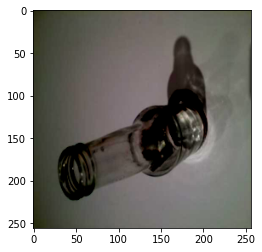

In [ ]:
img, label = dataset[569]
show_sample(img, label)

# Loading Data

In [ ]:
# Set Random Seed
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
from torch.utils import data
train_ds, val_ds, test_ds = data.random_split(dataset, [1593, 176, 758])
len(train_ds), len(val_ds), len(test_ds)

(1593, 176, 758)

In [ ]:
train_ds

In [ ]:
val_ds

In [ ]:
test_ds

Data Augmentation

In [ ]:
from torch.utils.data import ConcatDataset

aug_flag = 0 # 0: no augmentation; 1: augmentation

class dataAug():
  def __init__(self,data,transforms = None):
    self.data = data
    self.transforms = transforms
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    x, y = self.data[index]
        
    if self.transforms:
      x = self.transforms(x)
        
    return x, y

augTrans = transforms.Compose([transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomRotation(15),
     transforms.RandomHorizontalFlip(p=0.5)])
if aug_flag==1:
  train_aug = dataAug(train_ds,augTrans)
  train_ds = ConcatDataset([train_ds,train_aug])
  print(len(train_ds))

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 2, pin_memory = True)
test_dl = DataLoader(test_ds,batch_size*2, num_workers = 2, pin_memory = True)

In [ ]:
#Helper function to visualize batches
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


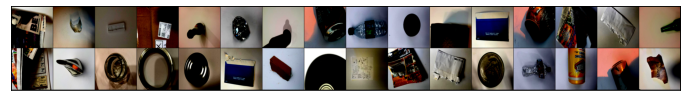

In [ ]:
show_batch(train_dl)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


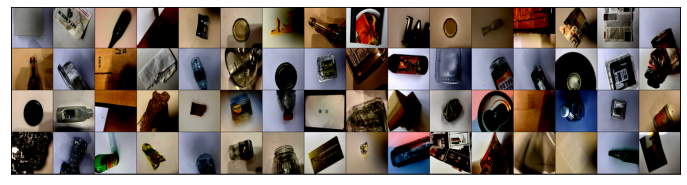

In [ ]:
show_batch(val_dl)

# ResNet-50


Reference1: https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

Reference2: https://debuggercafe.com/transfer-learning-with-pytorch/

## Loading Model

In [ ]:
from torchvision import models
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
print(model)

## Freeze weights & Update classifier

In [ ]:
# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

In [ ]:
import torch.nn as nn
# Add on classifier
num_ftrs = model.fc.in_features
# model.fc = nn.Sequential(
#                       nn.Linear(num_ftrs, 256), 
#                       nn.ReLU(), 
#                       nn.Dropout(0.4),
#                       nn.Linear(256, 64),
#                       nn.ReLU(),
#                       nn.Dropout(0.2), 
#                       nn.Linear(64, len(classes)),
#                       nn.LogSoftmax(dim=1))
model.fc = nn.Linear(num_ftrs,len(classes))

In [ ]:
model.fc

Linear(in_features=2048, out_features=6, bias=True)

In [ ]:
model

## Training

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
model = model.cuda()

In [ ]:
from torchsummary import summary
summary(model, input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
from torch import optim
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
def get_validaion_loss(model):
  loss = 0
  total = 0 
  with torch.no_grad():
    for data in val_dl:
        images, labels = data
        total += labels.size(0)
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss += criterion(outputs, labels).item()
  return loss / total
        # _, predicted = torch.max(outputs.data, 1)
        # total += labels.size(0)
        # correct += (predicted == labels.cuda()).sum().item()

In [ ]:
training_loss = []
validaion_loss = []
model_val_best = model
val_best = 1000
for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # print(loss.item())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 0:    # print every epoch
          print('Epoch: %d loss: %.3f' % (epoch + 1, running_loss/50))
          training_loss.append(running_loss/50)
          val_acc = get_validaion_loss(model)
          validaion_loss.append(val_acc)
          print("val:", val_acc)
          running_loss = 0.0
          if val_best > val_acc:
            model_val_best = model
            val_best = val_acc

print('Finished Training')
# torch.save(model_val_best, 'baseline_model.pth')

Epoch: 1 loss: 0.037
val: 0.02978171611374075
Epoch: 2 loss: 0.020
val: 0.018105778165838936
Epoch: 3 loss: 0.015
val: 0.01401002603498372
Epoch: 4 loss: 0.017
val: 0.012443156743591482
Epoch: 5 loss: 0.010
val: 0.011304543099620125
Epoch: 6 loss: 0.012
val: 0.010442326353354887
Epoch: 7 loss: 0.012
val: 0.0101614176211032
Epoch: 8 loss: 0.010
val: 0.009414938532493332
Epoch: 9 loss: 0.008
val: 0.009362761777910318
Epoch: 10 loss: 0.009
val: 0.009113829413598234
Epoch: 11 loss: 0.009
val: 0.009368804198774424
Epoch: 12 loss: 0.006
val: 0.008530356497927145
Epoch: 13 loss: 0.006
val: 0.008626843040639704
Epoch: 14 loss: 0.010
val: 0.008104361593723297
Epoch: 15 loss: 0.007
val: 0.009215677326375788
Epoch: 16 loss: 0.005
val: 0.007978578690778126
Epoch: 17 loss: 0.010
val: 0.008434167131781578
Epoch: 18 loss: 0.006
val: 0.008268320424990221
Epoch: 19 loss: 0.008
val: 0.007784758779135617
Epoch: 20 loss: 0.005
val: 0.007865957746451551
Epoch: 21 loss: 0.006
val: 0.007839251648296009
Epoch

AttributeError: ignored

In [ ]:
print(training_loss, validaion_loss)

[0.03715173959732056, 0.020282294750213623, 0.015262717008590698, 0.01708046555519104, 0.009704142212867736, 0.012087652683258057, 0.011997380256652833, 0.009772005081176758, 0.008231064081192016, 0.00900677740573883, 0.008587360382080078, 0.0058049774169921875, 0.006022788286209106, 0.009922212958335876, 0.006601939797401428, 0.005214507579803467, 0.009968153238296508, 0.00553152859210968, 0.007610995769500733, 0.005235892534255981, 0.005647199749946594, 0.0057336133718490605, 0.004690991044044495, 0.005837400555610657, 0.006388052105903625, 0.006257972121238709, 0.003947716355323792, 0.003934029936790467, 0.004278634786605835, 0.004942671358585358] [0.02978171611374075, 0.018105778165838936, 0.01401002603498372, 0.012443156743591482, 0.011304543099620125, 0.010442326353354887, 0.0101614176211032, 0.009414938532493332, 0.009362761777910318, 0.009113829413598234, 0.009368804198774424, 0.008530356497927145, 0.008626843040639704, 0.008104361593723297, 0.009215677326375788, 0.007978578690

Text(0.5, 1.0, 'ResNet50')

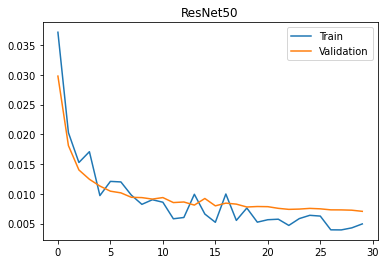

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(training_loss)
plt.plot(validaion_loss)
plt.legend(['Train', 'Validation'])
plt.title('ResNet50')

## Test

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dl)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

In [ ]:
# Test - output
model = model_val_best
outputs = model(images.cuda())
_, predicted = torch.max(outputs, 1)
print(predicted)
# print(classes[predicted[0]])
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(len(predicted))))

In [ ]:
nb_classes = 6

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for inputs, classes in train_dl:
        inputs = inputs.cuda()
        classes = classes.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

# To get the per-class accuracy: precision
precision = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

recall = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(0))

f1 = 2*precision*recall/(precision+recall)
print(f1)
print("Training F score", f1.numpy().mean())

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_dl:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(100 * correct / total)
print('Accuracy of the network on the 1593 training images: %d %%' % (
    100 * correct / total))

In [ ]:
nb_classes = 6

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for inputs, classes in val_dl:
        inputs = inputs.cuda()
        classes = classes.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

# To get the per-class accuracy: precision
precision = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

recall = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(0))

f1 = 2*precision*recall/(precision+recall)
print(f1)
print("Validation F score", f1.numpy().mean())

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in val_dl:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(100 * correct / total)
print('Accuracy of the network on the 176 validation images: %d %%' % (
    100 * correct / total))

In [ ]:
nb_classes = 6

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for inputs, classes in test_dl:
        inputs = inputs.cuda()
        classes = classes.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

# To get the per-class accuracy: precision
precision = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(1))

recall = confusion_matrix.diag()/confusion_matrix.sum(1)
print(confusion_matrix.diag()/confusion_matrix.sum(0))

f1 = 2*precision*recall/(precision+recall)
print(f1)
print("Test F score", f1.numpy().mean())

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        outputs = model(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(100 * correct / total)
print('Accuracy of the network on the 758 test images: %d %%' % (
    100 * correct / total))